# Monolingual Embedding - Fine Tunning on Arabiv Before Testing

In [1]:
import os
from gensim.models import KeyedVectors

english_embedding_path = "C:/Users/ALI/Desktop/wikis/wiki.en.vec"
arabic_embedding_path = "C:/Users/ALI/Desktop/wikis/Arabic fastText/wiki.ar.vec"

en_embeddings = KeyedVectors.load_word2vec_format(english_embedding_path)
ar_embeddings = KeyedVectors.load_word2vec_format(arabic_embedding_path)

In [2]:
import nltk
import numpy as np
from wordfreq import word_frequency
from sklearn.decomposition import TruncatedSVD


def compute_sentence_embeddings(questions, word_embeddings, language, a=0.001): 
    
    question_embeddings = []
    for question in questions: 
        tokens = [t.lower() for t in nltk.word_tokenize(question)]
        tokens = [token for token in tokens if token in word_embeddings]

        weights = [a/(a+word_frequency(token, language)) for token in tokens]
        embedding = np.average([word_embeddings[token] for token in tokens], axis=0, weights=weights)
        question_embeddings.append(embedding)
        
    return question_embeddings

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('/Users/ALI/Desktop/IMDB Dataset.csv')

# Apply sentence embeddings to first column of dataframe
reviews = df.iloc[:, 0].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, en_embeddings, "en")

# Add new column with embeddings to dataframe
df['English_Embeddings'] = reviews_embeddings
df['sentiment_binary'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Separate the input features (sentence embeddings) and output labels (sentiment)
X = np.vstack(df["English_Embeddings"])  # input features (sentence embeddings)
y = df["sentiment_binary"]  # output labels (sentiment)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
import tensorflow as tf
# Define a model using the Keras API
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(128, input_dim=300, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compile the model with binary crossentropy loss and Adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [5]:

# Train English Model
snn = model.fit(X_train, y_train, epochs = 11, 
          batch_size = 32, shuffle=True, 
          validation_data=(X_test, y_test))



Epoch 1/11
1250/1250 [==============================] - 3s 2ms/step - loss: 0.4756 - accuracy: 0.7768 - val_loss: 0.4076 - val_accuracy: 0.8173
Epoch 2/11
1250/1250 [==============================] - 3s 2ms/step - loss: 0.3973 - accuracy: 0.8243 - val_loss: 0.3854 - val_accuracy: 0.8290
Epoch 3/11
1250/1250 [==============================] - 3s 2ms/step - loss: 0.3864 - accuracy: 0.8302 - val_loss: 0.4030 - val_accuracy: 0.8157
Epoch 4/11
1250/1250 [==============================] - 3s 2ms/step - loss: 0.3768 - accuracy: 0.8335 - val_loss: 0.4473 - val_accuracy: 0.7918
Epoch 5/11
1250/1250 [==============================] - 3s 2ms/step - loss: 0.3719 - accuracy: 0.8361 - val_loss: 0.3731 - val_accuracy: 0.8346
Epoch 6/11
1250/1250 [==============================] - 3s 2ms/step - loss: 0.3693 - accuracy: 0.8366 - val_loss: 0.3687 - val_accuracy: 0.8374
Epoch 7/11
1250/1250 [==============================] - 3s 2ms/step - loss: 0.3663 - accuracy: 0.8394 - val_loss: 0.3762 - val_accuracy:

In [6]:
from sklearn.metrics import classification_report
# Evaluate the performance of the model on the testing set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred))

313/313 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      4961
           1       0.86      0.82      0.84      5039

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



[[4284  677]
 [ 912 4127]]


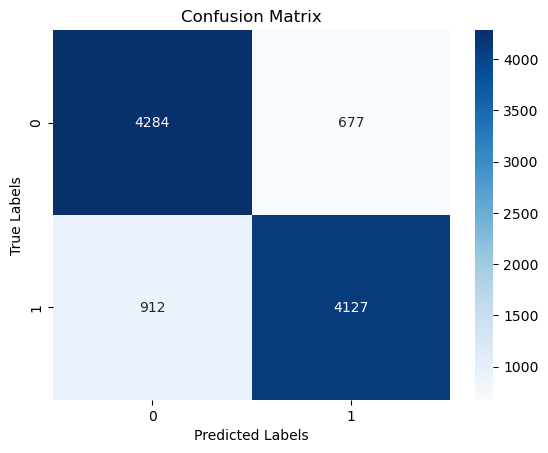

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

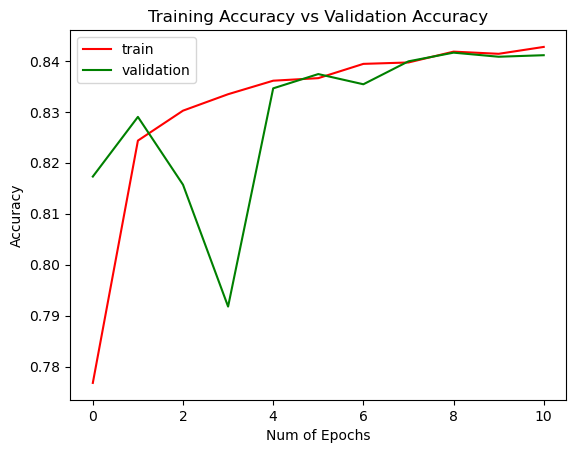

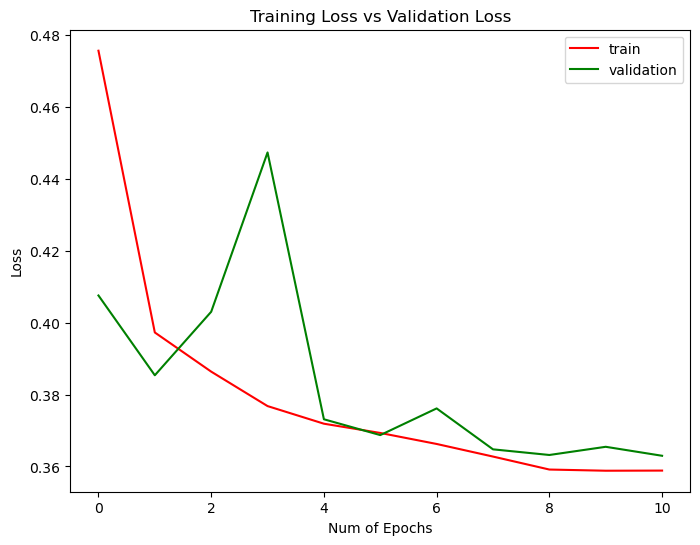

In [8]:
import matplotlib.pyplot as plt
print(snn)

# Results
plt.figure(0)  
plt.plot(snn.history['accuracy'],'r')  
plt.plot(snn.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(snn.history['loss'],'r')  
plt.plot(snn.history['val_loss'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show()

In [9]:
model.save("CrossLnigualModel_MonoLingualEmbedding_WithFineTune_Report.h5")

C:\Users\ALI\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Fine Tunning on Arabic

In [10]:
from tensorflow.keras.models import load_model

# Load the saved Keras model
model = load_model("CrossLnigualModel_MonoLingualEmbedding_WithFineTune_Report.h5")

In [11]:
df_ = pd.read_excel('../../base-line/balanced-reviews.xlsx')
print(df_.shape)
# df = df.head(500)
# Select the first 500 rows of the dataset
df = df_.iloc[:500]

# Select the next 500 rows of the dataset
df2 = df_.iloc[500:1000]
# print(df1.shape)
print(df2.shape)
# df.head()

# determine the minimum number of rows for each rating value
min_count = df["rating"].value_counts().min()
min_count = 40
# subset the original dataset for each rating value
df_1 = df[df["rating"] == 1]
df_2 = df[df["rating"] == 2]
df_4 = df[df["rating"] == 4]
df_5 = df[df["rating"] == 5]

# randomly sample the minimum number of rows for each rating value
df_1_sampled = df_1.sample(n=min_count, random_state=42)
df_2_sampled = df_2.sample(n=min_count, random_state=42)
df_4_sampled = df_4.sample(n=min_count, random_state=42)
df_5_sampled = df_5.sample(n=min_count, random_state=42)

# combine the sampled rows for each rating value into a new dataset
df_balanced = pd.concat([df_1_sampled, df_2_sampled, df_4_sampled, df_5_sampled])

# save the balanced dataset to a new file
df_balanced.to_csv("balanced_dataset.csv", index=False)

df = pd.read_csv('balanced_dataset.csv')
# Define a function to map the rating to sentiment
def map_sentiment(rating):
    if rating in [1, 2]:
        return "negative"
    elif rating in [4, 5]:
        return "positive"
    else:
        raise ValueError("Invalid rating value: {}".format(rating))

# Apply the function to the 'rating' column and create a new 'sentiment' column
df['sentiment'] = df['rating'].apply(map_sentiment)

# Apply sentence embeddings to first column of dataframe
reviews = df['review'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, ar_embeddings, "ar")

# Add new column with embeddings to dataframe
df['arabic_Embeddings'] = reviews_embeddings

import pandas as pd
from sklearn.model_selection import train_test_split



X = np.vstack(df['arabic_Embeddings']) 
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


(105698, 7)
(500, 7)


In [12]:
y_train
from sklearn.preprocessing import LabelEncoder
# create a LabelEncoder object
le = LabelEncoder()

# fit the encoder to the values and transform the values to binary values
binary_y_train = le.fit_transform(y_train)
binary_y_train

array([0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1])

In [13]:
from sklearn.metrics import accuracy_score, classification_report
snn = model.fit(X_train, binary_y_train)

# Evaluate the performance of the Model on the testing set
y_pred = model.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)
y_pred

1/1 [==============================] - 0s 39ms/step


array([[6.6455650e-01],
       [6.1109103e-03],
       [4.5878381e-01],
       [9.3987298e-01],
       [7.5976431e-02],
       [9.7030324e-01],
       [9.9842733e-01],
       [4.7997883e-01],
       [2.1500023e-01],
       [9.9997139e-01],
       [1.4880966e-05],
       [5.5397803e-01],
       [1.8425828e-01],
       [9.8530275e-01],
       [9.7729021e-01],
       [2.3227891e-02],
       [8.3602762e-01],
       [6.3151971e-02],
       [4.1536537e-01],
       [2.3365727e-02],
       [9.2411959e-01],
       [6.9209415e-01],
       [7.0040387e-01],
       [2.0572528e-01],
       [1.0624658e-01],
       [5.4696536e-01],
       [6.8886161e-01],
       [2.2775161e-03],
       [9.1539115e-01],
       [9.7490185e-01],
       [8.2795596e-01],
       [2.2491281e-01]], dtype=float32)

In [14]:
import numpy as np

# example threshold value
threshold = 0.5
# convert values to binary using threshold
binary_y_pred = np.where(y_pred > threshold, 1, 0)

print(binary_y_pred)
# convert values to binary using threshold
binary_y_test = le.fit_transform(y_test)
binary_y_test

[[1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]]


array([1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 0])

In [15]:
accuracy = accuracy_score(binary_y_test, binary_y_pred)
print("Accuracy:", accuracy)

print(classification_report(binary_y_test, binary_y_pred))

Accuracy: 0.59375
              precision    recall  f1-score   support

           0       0.60      0.56      0.58        16
           1       0.59      0.62      0.61        16

    accuracy                           0.59        32
   macro avg       0.59      0.59      0.59        32
weighted avg       0.59      0.59      0.59        32



In [19]:

# determine the minimum number of rows for each rating value
min_count = df2["rating"].value_counts().min()
min_count = 40
# subset the original dataset for each rating value
df_1 = df2[df2["rating"] == 1]
df_2 = df2[df2["rating"] == 2]
df_4 = df2[df2["rating"] == 4]
df_5 = df2[df2["rating"] == 5]

# randomly sample the minimum number of rows for each rating value
df_1_sampled = df_1.sample(n=min_count, random_state=42)
df_2_sampled = df_2.sample(n=min_count, random_state=42)
df_4_sampled = df_4.sample(n=min_count, random_state=42)
df_5_sampled = df_5.sample(n=min_count, random_state=42)

# combine the sampled rows for each rating value into a new dataset
df_balanced = pd.concat([df_1_sampled, df_2_sampled, df_4_sampled, df_5_sampled])

# save the balanced dataset to a new file
df_balanced.to_csv("balanced_dataset.csv", index=False)

df = pd.read_csv('balanced_dataset.csv')
# Define a function to map the rating to sentiment
def map_sentiment(rating):
    if rating in [1, 2]:
        return "negative"
    elif rating in [4, 5]:
        return "positive"
    else:
        raise ValueError("Invalid rating value: {}".format(rating))

# Apply the function to the 'rating' column and create a new 'sentiment' column
df['sentiment'] = df['rating'].apply(map_sentiment)

# Apply sentence embeddings to first column of dataframe
reviews = df['review'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, ar_embeddings, "ar")

# Add new column with embeddings to dataframe
df['arabic_Embeddings'] = reviews_embeddings



In [20]:
X_test = np.vstack(df['arabic_Embeddings']) 
y_test = df['sentiment']
y_pred = model.predict(X_test)


5/5 [==============================] - 0s 2ms/step


In [21]:
# example threshold value
threshold = 0.5
# convert values to binary using threshold
binary_y_pred = np.where(y_pred > threshold, 1, 0)

# print(binary_y_pred)
# convert values to binary using threshold
binary_y_test = le.fit_transform(y_test)
# binary_y_test

# accuracy = accuracy_score(binary_y_test, binary_y_pred)
# print("Accuracy:", accuracy)


accuracy = accuracy_score(binary_y_test, binary_y_pred)
report = classification_report(binary_y_test, binary_y_pred)
print("Accuracy:", accuracy)
print(report)

Accuracy: 0.4875
              precision    recall  f1-score   support

           0       0.49      0.54      0.51        80
           1       0.49      0.44      0.46        80

    accuracy                           0.49       160
   macro avg       0.49      0.49      0.49       160
weighted avg       0.49      0.49      0.49       160



[[43 37]
 [45 35]]


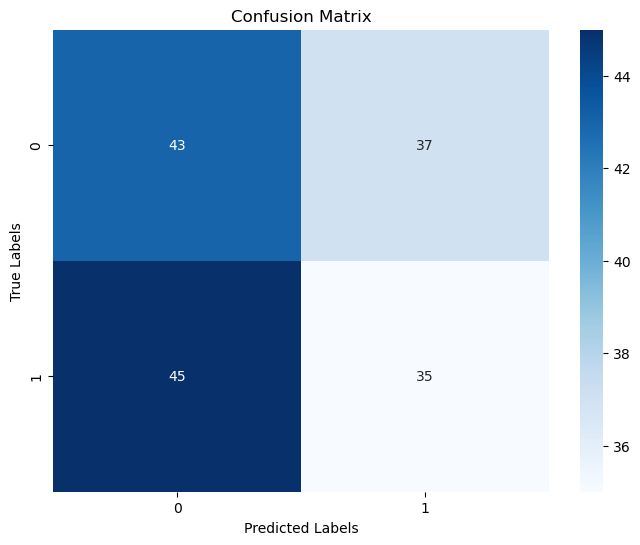

In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(binary_y_test, binary_y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()